# COSMOS master catalogue
## Preparation of Canada France Hawaii Telescope WIRDS Survey (CFHT-WIRDS) data

The catalogue is in `dmu0_CFHT-WIRDS`.

In the catalogue, we keep:

- The position;
- The stellarity;
- The aperture magnitude (3 arcsec).
- The total magnitude (Kron like aperture magnitude).



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "wirds_ra"
DEC_COL = "wirds_dec"

## I - Column selection

In [4]:
#We have to import and combine the H, J and Ks catalogues separately. 
#Fluxes are given in counts sowe compute them fresh from the magnitudes

epoch = 2007

imported_columns_h = OrderedDict({
        'NUMBER': "wirds_h_id",
        'ALPHA_J2000': "wirds_h_ra",
        'DELTA_J2000': "wirds_h_dec",
        'CLASS_STAR':  "wirds_h_stellarity",
        'MAG_APER': "m_ap_wirds_h",
        'MAGERR_APER': "merr_ap_wirds_h",
        'MAG_AUTO': "m_wirds_h",
        'MAGERR_AUTO': "merr_wirds_h"
        #'FLUX_APER': "f_ap_wirds_h",
        #'FLUXERR_APER': "ferr_ap_wirds_h",
        #'FLUX_AUTO': "f_wirds_h",
        #'FLUXERR_AUTO': "ferr_wirds_h"
        
    })


catalogue_h = Table.read("../../dmu0/dmu0_CFHT-WIRDS/data/COSMOS_H.fits")[list(imported_columns_h)]
for column in imported_columns_h:
    catalogue_h[column].name = imported_columns_h[column]

for col in catalogue_h.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        #catalogue_h[col].name = imported_columns_h[col]
    
        flux, error = mag_to_flux(np.array(catalogue_h[col]), np.array(catalogue_h[errcol]))
        
        # Fluxes are added in µJy
        catalogue_h.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue_h.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue_h.add_column(Column(np.zeros(len(catalogue_h), dtype=bool), name="flag{}".format(col[1:])))
        
# Clean table metadata
catalogue_h.meta = None



imported_columns_j = OrderedDict({
        'NUMBER': "wirds_j_id",
        'ALPHA_J2000': "wirds_j_ra",
        'DELTA_J2000': "wirds_j_dec",
        'CLASS_STAR':  "wirds_j_stellarity",
        'MAG_APER': "m_ap_wirds_j",
        'MAGERR_APER': "merr_ap_wirds_j",
        'MAG_AUTO': "m_wirds_j",
        'MAGERR_AUTO': "merr_wirds_j"
        #'FLUX_APER': "f_ap_wirds_j",
        #'FLUXERR_APER': "ferr_ap_wirds_j",
        #'FLUX_AUTO': "f_wirds_j",
        #'FLUXERR_AUTO': "ferr_wirds_j"
        
    })


catalogue_j = Table.read("../../dmu0/dmu0_CFHT-WIRDS/data/COSMOS_J.fits")[list(imported_columns_j)]
for column in imported_columns_j:
    catalogue_j[column].name = imported_columns_j[column]
    
for col in catalogue_j.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        #catalogue_h[col].name = imported_columns_h[col]
    
        flux, error = mag_to_flux(np.array(catalogue_j[col]), np.array(catalogue_j[errcol]))
        
        # Fluxes are added in µJy
        catalogue_j.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue_j.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue_j.add_column(Column(np.zeros(len(catalogue_j), dtype=bool), name="flag{}".format(col[1:])))
# Clean table metadata
catalogue_j.meta = None



imported_columns_ks = OrderedDict({
        'NUMBER': "wirds_ks_id",
        'ALPHA_J2000': "wirds_ks_ra",
        'DELTA_J2000': "wirds_ks_dec",
        'CLASS_STAR':  "wirds_ks_stellarity",
        'MAG_APER': "m_ap_wirds_ks",
        'MAGERR_APER': "merr_ap_wirds_ks",
        'MAG_AUTO': "m_wirds_ks",
        'MAGERR_AUTO': "merr_wirds_ks"
        #'FLUX_APER': "f_ap_wirds_ks",
        #'FLUXERR_APER': "ferr_ap_wirds_ks",
        #'FLUX_AUTO': "f_wirds_ks",
        #'FLUXERR_AUTO': "ferr_wirds_ks"
        
    })


catalogue_ks = Table.read("../../dmu0/dmu0_CFHT-WIRDS/data/COSMOS_Ks.fits")[list(imported_columns_ks)]
for column in imported_columns_ks:
    catalogue_ks[column].name = imported_columns_ks[column]

for col in catalogue_ks.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        #catalogue_h[col].name = imported_columns_h[col]
    
        flux, error = mag_to_flux(np.array(catalogue_ks[col]), np.array(catalogue_ks[errcol]))
        
        # Fluxes are added in µJy
        catalogue_ks.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue_ks.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue_ks.add_column(Column(np.zeros(len(catalogue_ks), dtype=bool), name="flag{}".format(col[1:])))
# Clean table metadata
catalogue_ks.meta = None


## Merging different bands
CFHT-WIRDS has indivdual extractions from each band. We must therefore merge them as if they were individual catalogues (they have different

In [5]:
catalogue_ks[:10].show_in_notebook()

idx,wirds_ks_id,wirds_ks_ra,wirds_ks_dec,wirds_ks_stellarity,m_ap_wirds_ks,merr_ap_wirds_ks,m_wirds_ks,merr_wirds_ks,f_ap_wirds_ks,ferr_ap_wirds_ks,f_wirds_ks,ferr_wirds_ks,flag_wirds_ks
,,deg,deg,,mag,mag,mag,mag,,,,,
0,1,149.6406419,1.7301753,0.96,13.2109,0.0001,12.1115,0.0001,18864.269837,1.73746346067,51927.8091541,4.7827279708,False
1,2,149.828627,1.7247336,0.03,16.6672,0.0003,15.6748,0.0005,781.843806172,0.216031427177,1950.20380749,0.898102043085,False
2,3,149.8262472,1.7172161,1.0,13.289,0.0,12.932,0.0,17554.9662962,0.0,24389.3373028,0.0,False
3,4,149.6261489,1.7188406,0.99,13.4017,0.0001,13.0011,0.0001,15824.1357523,1.45745676371,22885.4786431,2.10783047878,False
4,5,149.9132691,1.7144459,0.98,12.9989,0.0,12.5339,0.0,22931.8979268,0.0,35191.6800063,0.0,False
5,6,149.9166838,1.7108627,0.98,17.0592,0.0004,16.8771,0.0009,544.904005069,0.20075005427,644.406629964,0.534168395994,False
6,7,149.9790552,1.7162439,1.0,14.9653,0.0001,14.826,0.0001,3748.69407689,0.345267483986,4261.86805424,0.392532554,False
7,8,149.807708,1.7156341,0.03,18.6449,0.0014,17.6467,0.0028,126.485283936,0.163096152393,317.190374727,0.818000767906,False
8,9,150.2731697,1.7146767,0.03,17.7393,0.0007,16.7139,0.0011,291.259433182,0.187781896131,748.927883152,0.758766878969,False


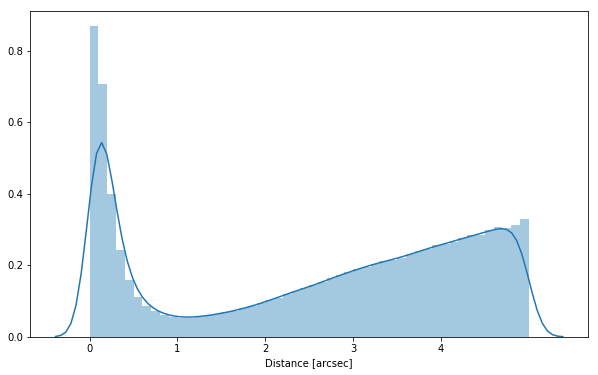

In [6]:
nb_merge_dist_plot(
    SkyCoord(catalogue_ks['wirds_ks_ra'], catalogue_ks['wirds_ks_dec']),
    SkyCoord(catalogue_j['wirds_j_ra'], catalogue_j['wirds_j_dec'])
)

In [7]:
catalogue = catalogue_ks
catalogue_ks['wirds_ks_ra'].name = 'ra'
catalogue_ks['wirds_ks_dec'].name = 'dec'
# Given the graph above, we use 0.8 arc-second radius
catalogue = merge_catalogues(catalogue, catalogue_j, "wirds_j_ra", "wirds_j_dec", radius=0.8*u.arcsec)

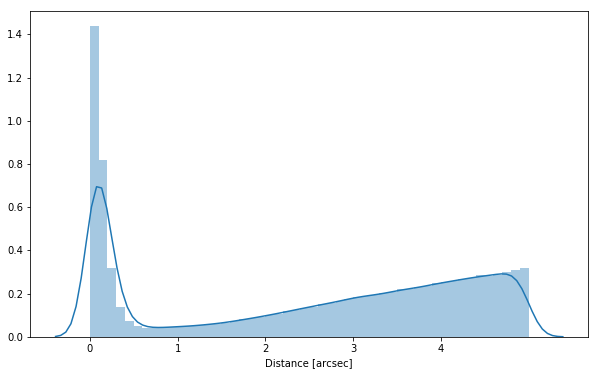

In [8]:
nb_merge_dist_plot(
    SkyCoord(catalogue['ra'], catalogue['dec']),
    SkyCoord(catalogue_h['wirds_h_ra'], catalogue_h['wirds_h_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
catalogue = merge_catalogues(catalogue, catalogue_h, "wirds_h_ra", "wirds_h_dec", radius=0.8*u.arcsec)


In [10]:
#rename radec colums
catalogue['ra'].name = 'wirds_ra'
catalogue['dec'].name = 'wirds_dec'

In [11]:

    
for col in catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        catalogue[col].fill_value = np.nan
    elif "flag" in col:
        catalogue[col].fill_value = 0
    elif "id" in col:
        catalogue[col].fill_value = 999999
        
catalogue =  catalogue.filled()

## Generate internal id
Since every source has an independent id we combine them in 6 digit groups so that each iondividual id can be retrieved from the final integer

In [12]:
wirds_intid = catalogue['wirds_ks_id'] + catalogue['wirds_j_id']*10**6 + catalogue['wirds_h_id']*10**12

In [13]:
catalogue.add_column(Column(data=wirds_intid, name="wirds_intid"))
catalogue.remove_columns(['wirds_ks_id','wirds_j_id','wirds_h_id'])

In [14]:
stellarity_columns = [column for column in catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

wirds_ks_stellarity, wirds_j_stellarity, wirds_h_stellarity


In [15]:
# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

catalogue.add_column(Column(data=max_stellarity.filled(), name="wirds_stellarity"))

catalogue.remove_columns(stellarity_columns)
catalogue['flag_merged'].name = 'wirds_flag_merged'

In [16]:
catalogue[:10].show_in_notebook()

idx,wirds_ra,wirds_dec,m_ap_wirds_ks,merr_ap_wirds_ks,m_wirds_ks,merr_wirds_ks,f_ap_wirds_ks,ferr_ap_wirds_ks,f_wirds_ks,ferr_wirds_ks,flag_wirds_ks,wirds_flag_merged,m_ap_wirds_j,merr_ap_wirds_j,m_wirds_j,merr_wirds_j,f_ap_wirds_j,ferr_ap_wirds_j,f_wirds_j,ferr_wirds_j,flag_wirds_j,m_ap_wirds_h,merr_ap_wirds_h,m_wirds_h,merr_wirds_h,f_ap_wirds_h,ferr_ap_wirds_h,f_wirds_h,ferr_wirds_h,flag_wirds_h,wirds_intid,wirds_stellarity
,deg,deg,mag,mag,mag,mag,,,,,,,mag,mag,mag,mag,,,,,,mag,mag,mag,mag,,,,,,,
0,149.6407012,1.7131773,22.1175,0.0485,19.7932,0.0356,5.16416369272,0.230683970931,43.9258323818,1.4402758478,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000014,0.0
1,150.3665909,1.7088445,22.781,0.0652,20.6362,0.0388,2.80285092765,0.168315176082,20.2078449041,0.722149983435,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000027,0.0
2,150.5812943,1.710091,23.1038,0.0798,21.6588,0.0606,2.08199652353,0.153023655147,7.87916145736,0.439772738741,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000029,0.0
3,149.6404403,1.7096119,21.9589,0.0427,20.3434,0.0468,5.97640471902,0.235040961501,26.4630562538,1.14067397518,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000048,0.0
4,149.6409936,1.709405,22.4803,0.0753,21.7536,0.081,3.69726006594,0.256419268092,7.2203790927,0.538667407374,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000049,0.49
5,150.5883657,1.7084932,22.9845,0.0649,21.4384,0.048,2.32380670252,0.138905798971,9.6525042163,0.426733676516,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000096,0.0
6,150.5889012,1.7091271,22.9219,0.0655,21.7717,0.0626,2.46172762929,0.148510438366,7.10100796852,0.409420904342,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000097,0.0
7,149.9638945,1.7092403,23.7,0.1477,23.6293,0.1699,1.20226443462,0.163552119027,1.28315759831,0.200793226749,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000103,0.51
8,149.7565523,1.7090922,23.4719,0.1334,23.471,0.1634,1.48333758133,0.182251667101,1.48456767505,0.223422924501,False,False,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,999999999999000110,0.67


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [17]:
SORT_COLS = ['merr_ap_wirds_ks',
            'merr_ap_wirds_j',
            'merr_ap_wirds_h']
FLAG_NAME = 'wirds_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 447687 sources.
The cleaned catalogue has 447668 sources (19 removed).
The cleaned catalogue has 19 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [18]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

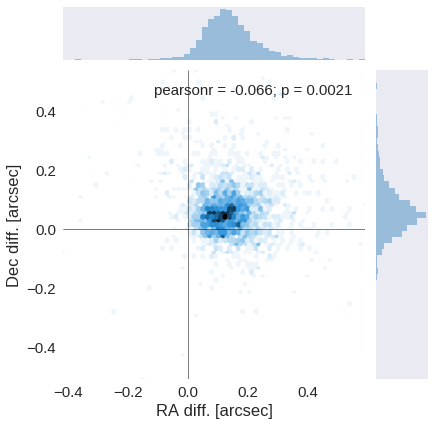

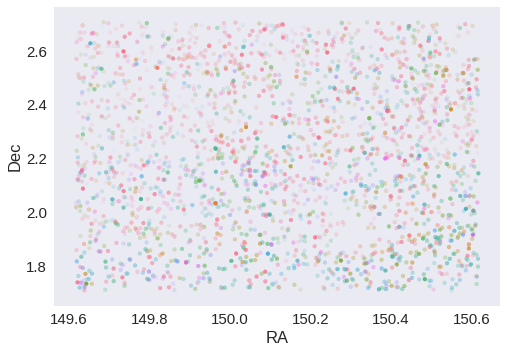

In [19]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [20]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.13158172980638483 arcsec
Dec correction: -0.05163567519641532 arcsec


In [21]:
catalogue[RA_COL] = catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

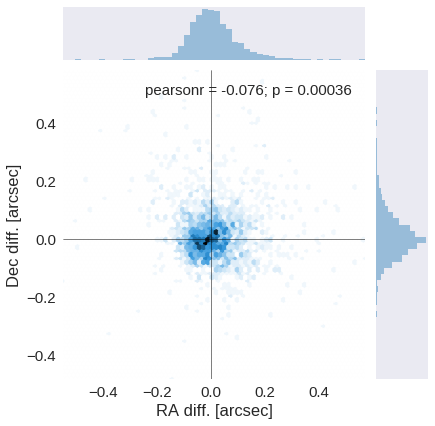

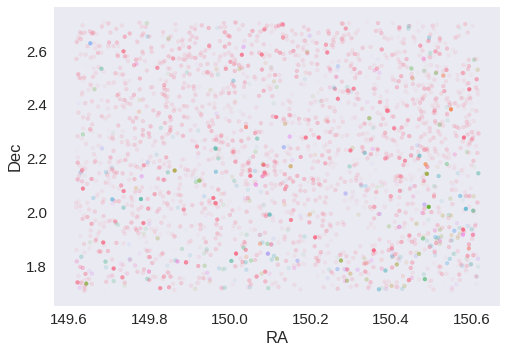

In [22]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [23]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [24]:
GAIA_FLAG_NAME = "cfht-wirds_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2256 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [25]:
catalogue.write("{}/CFHT-WIRDS.fits".format(OUT_DIR), overwrite=True)